In [8]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../src')
from utils import w_label_prop
from quality_functions import eval_functions
from parse_data import parse_6dfb

N_NODES = 15801
def read_graph(path="../datasets/fb_dg_gabr"):
    graph = nx.Graph()
    for i in range(N_NODES):
        graph.add_node(i)
    for v, line in enumerate(open(path)):
        edges = map(int, line.split())
        for u in edges:
            graph.add_edge(v, u)
    return graph

graph_conn = parse_6dfb()
labels_conn, _ = w_label_prop(graph_conn)

100%|██████████| 10/10 [00:44<00:00,  4.24s/it]


EPS
N_nodes: 15801
N_edges: 117864
Ratio: 7.459274729447503
N_comm: 3493
UNSHUFFLED
global_density : 0.7283746137775997
local_density : 0.803810334564022
distance_based : 0.9988350216891508
node_membership : 0.8038103345640216
SHUFFLED
global_density : 0.5173242766557538
local_density : 0.6104423874146728
distance_based : 0.9972942136899262
node_membership : 0.6104423874146728

GABR
N_nodes: 15801
N_edges: 109121
Ratio: 6.905955319283589
N_comm: 353
UNSHUFFLED
global_density : 0.5541824221764018
local_density : 0.5940794896990065
distance_based : 0.9940590359734185
node_membership : 0.5940794896990039
SHUFFLED
global_density : 0.5049558274726385
local_density : 0.511171649668958
distance_based : 0.9928084492076453
node_membership : 0.5111716496689573

INF
N_nodes: 15801
N_edges: 15410
Ratio: 0.975254730713246
N_comm: 6052
UNSHUFFLED
global_density : 0.6909305860449404
local_density : 0.7573668017476534
distance_based : 0.9997401306366438
node_membership : 0.7573668017476454
SHUFFLED
gl

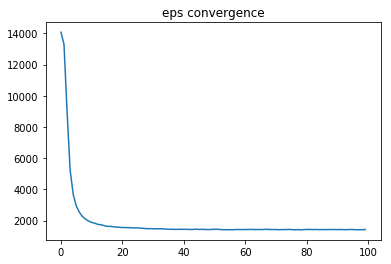

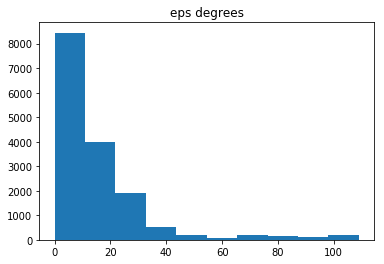

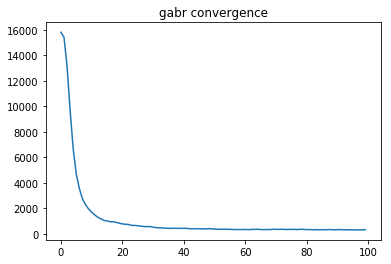

In [ ]:
%%time

dg_labels = dict()

for fname in ['eps', 'gabr', 'inf', 'knn', 'rng']:
    print(fname.upper())
    graph = read_graph('../datasets/fb_dg_' + fname)
    print("N_nodes:", graph.number_of_nodes())
    print("N_edges:", graph.number_of_edges())
    print("Ratio:", graph.number_of_edges() / graph.number_of_nodes())
    labels, deltas = w_label_prop(graph)
    dg_labels[fname] = labels
    plt.title(fname + " convergence")
    plt.plot(deltas)
    plt.figure()
    plt.title(fname + " degrees")
    plt.hist([graph.degree(i) for i in graph.nodes()])
    plt.figure()
    print("N_comm:", len(set(labels)))
    eval_functions(labels, graph)
    print()

In [12]:
def cnt_equal(array):
    cnt = dict()
    for i in array:
        if i in cnt:
            cnt[i] += 1
        else:
            cnt[i] = 1
    ans = 0
    for i in cnt.values():
        ans += (i * (i - 1)) // 2
    return ans
        

def get_n_pairs(labels_1, labels_2):
    return cnt_equal(labels_1), cnt_equal(labels_2), cnt_equal(list(zip(labels_1, labels_2)))

for fname in ['eps', 'gabr', 'inf', 'knn', 'rng']:
    cnt_conn, cnt_dg, cnt_common = get_n_pairs(labels_conn, dg_labels[fname])
    print(fname)
    print(cnt_conn, cnt_dg, cnt_common)
    n_pairs = N_NODES * (N_NODES - 1) // 2
    print((cnt_common * n_pairs) / (cnt_conn * cnt_dg))

eps
41938332 227694 125089
1.6351893315369712
gabr
41938332 925582 646907
2.0803071478460686
inf
41938332 30279 18549
1.8233896453274945
knn
41938332 105696 69560
1.958851584683539
rng
41938332 241271 169885
2.09580282407564
